# Etapa 1 - Enriquecimiento con VADER
Esta primera etapa del notebook lee **Data/raw/**, aplica limpieza mínima, añade analisis de sentimientos con **VADER** y heurísticos, agrega métricas por post y comentariosn y guarda **CSV + JSONL** en **Data/enriched/**.

## Librerias

In [1]:
# Ejecutar esta celda para instalar las siguientes dependencias:
# ```bash
# pip install pandas tqdm vaderSentiment regex
# ``

In [2]:
from pathlib import Path
import json, re
import pandas as pd
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Parámetros

In [3]:
DATA_DIR = Path("data")          # base de datos
RAW_DIR = DATA_DIR / "raw"       # carpeta con la corrida cruda
ENRICHED_DIR = DATA_DIR / "enriched"  # carpeta para datos enriquecidos
ENRICHED_DIR.mkdir(parents=True, exist_ok=True)

# Heurísticos acuerdo/desacuerdo (EN/ES). Puedes ampliar listas.
AGREE_TERMS = [
    r"\bi agree\b", r"\bagree\b", r"\bsupported\b", r"\bsupport this\b", r"\bi support\b", r"\bvalid point\b",
    r"\bde acuerdo\b", r"\bapoyo\b", r"\btiene raz[oó]n\b", r"\bcierto\b", r"\btotalmente de acuerdo\b", r"\bestoy de acuerdo\b",
]
DISAGREE_TERMS = [
    r"\bi disagree\b", r"\bdisagree\b", r"\bnot support\b", r"\boppose\b", r"\bagainst this\b", r"\bbad take\b",
    r"\bno apoyo\b", r"\ben desacuerdo\b", r"\bno estoy de acuerdo\b", r"\bmala idea\b", r"\bme opongo\b",
]

# Expresiones regulares precompiladas
RE_URL = re.compile(r"https?://\S+")
RE_WS = re.compile(r"\s+")

## Utilidades

In [4]:
def latest_raw_dir(raw_base: Path) -> Path:
    """Obtiene la subcarpeta más reciente en raw_base."""
    subs = [p for p in raw_base.iterdir() if p.is_dir()]
    if not subs:
        raise FileNotFoundError(f"No hay subcarpetas en {raw_base}. Asegura haber corrido el scraper.")
    return sorted(subs)[-1]


def read_csv_or_jsonl(path_csv: Path, path_jsonl: Path) -> pd.DataFrame:
    """Lee un DataFrame desde CSV o JSONL, dependiendo de cuál exista."""
    if path_csv.exists():
        return pd.read_csv(path_csv)
    if path_jsonl.exists():
        return pd.read_json(path_jsonl, lines=True)
    raise FileNotFoundError(f"No se encontró ni {path_csv} ni {path_jsonl}")


def minimal_clean_for_vader(text: str) -> str:
    """Limpieza mínima: normaliza espacios y opcionalmente tokeniza URLs.
    Conserva mayúsculas, puntuación y emojis para VADER.
    """
    if not isinstance(text, str):
        return ""
    t = RE_URL.sub("URL", text)
    t = RE_WS.sub(" ", t).strip()
    return t


def count_hits_regex(text: str, patterns: list[str]) -> int:
    """Cuenta cuántos patrones en 'patterns' hacen match en 'text' (case insensitive)."""
    if not text:
        return 0
    t = text.lower()
    return sum(1 for pat in patterns if re.search(pat, t))

## Carga de datos crudos

In [5]:
posts_csv = RAW_DIR / "posts.csv"
comments_csv = RAW_DIR / "comments.csv"
posts_jsonl = RAW_DIR / "posts.jsonl"
comments_jsonl = RAW_DIR / "comments.jsonl"

posts = read_csv_or_jsonl(posts_csv, posts_jsonl)
comments = read_csv_or_jsonl(comments_csv, comments_jsonl)
print("Shapes RAW:", posts.shape, comments.shape)

# Asegura columnas básicas
req_posts = ["post_id","title","selftext","author","created","score","num_comments","permalink","is_self","image_urls","subreddit"]
for col in req_posts:
    if col not in posts.columns:
        posts[col] = None

req_comments = ["post_id","comment_id","author","created","score","body"]
for col in req_comments:
    if col not in comments.columns:
        comments[col] = None

Shapes RAW: (200, 11) (15131, 6)


## Limpieza mínima para VADER

In [6]:
# Limpieza mínima y features en posts
comments["body"] = comments["body"].fillna("")
comments["body_vader"] = comments["body"].map(minimal_clean_for_vader)
comments["has_url"] = comments["body"].str.contains(r"https?://", na=False)
comments["text_len"] = comments["body"].str.len().fillna(0)
comments["author_deleted"] = comments["author"].isin([None, "u/[deleted]"])
comments["is_bot"] = comments["author"].fillna("").str.contains("automoderator", case=False)

# Eliminar duplicados y conservar índices limpios
comments = comments.drop_duplicates(subset=["post_id","comment_id"]).reset_index(drop=True)
posts = posts.drop_duplicates(subset=["post_id"]).reset_index(drop=True)


## Aplicar VADER y heurísticos

In [7]:
# Aplica VADER
analyzer = SentimentIntensityAnalyzer()

# inicializa listas para scores
v_neg, v_neu, v_pos, v_comp = [], [], [], []

# Iterar y calcular scores
for txt in tqdm(comments["body_vader"].tolist(), desc="VADER"):
    scores = analyzer.polarity_scores(txt or "")
    v_neg.append(scores.get("neg", 0.0))
    v_neu.append(scores.get("neu", 0.0))
    v_pos.append(scores.get("pos", 0.0))
    v_comp.append(scores.get("compound", 0.0))

# Asigna scores a DataFrame
comments["vader_neg"] = v_neg
comments["vader_neu"] = v_neu
comments["vader_pos"] = v_pos
comments["vader_compound"] = v_comp

# Etiqueta a partir de compound (umbrales estándar)
comments["sentiment_label"] = pd.cut(
    comments["vader_compound"],
    bins=[-1.0, -0.5, 0.5, 1.0],
    labels=["neg","neu","pos"],
    include_lowest=True
)

# Heurísticos acuerdo/desacuerdo
comments["agrees"] = comments["body_vader"].map(lambda t: count_hits_regex(t, AGREE_TERMS))
comments["disagrees"] = comments["body_vader"].map(lambda t: count_hits_regex(t, DISAGREE_TERMS))

# Agregación por post
agg = (
    comments.groupby("post_id", group_keys=False)
    .apply(lambda g: pd.Series({
        "comments_total": g["comment_id"].count(),
        "comments_pos": (g["sentiment_label"] == "pos").sum(),
        "comments_neg": (g["sentiment_label"] == "neg").sum(),
        "comments_neu": (g["sentiment_label"] == "neu").sum(),
        "agree_hits": g["agrees"].sum(),
        "disagree_hits": g["disagrees"].sum(),
    }), include_groups=False)
    .reset_index()
)


# Calcula support_index con manejo de cero
num = agg["comments_pos"] + agg["agree_hits"]
denom = agg["comments_pos"] + agg["comments_neg"] + agg["agree_hits"] + agg["disagree_hits"]
agg["support_index"] = (num / denom.replace({0: pd.NA})).fillna(0.0).round(3)

# Une a posts
posts_proc = posts.merge(agg, on="post_id", how="left")
for col in ["comments_total","comments_pos","comments_neg","comments_neu","agree_hits","disagree_hits","support_index"]:
    if col not in posts_proc.columns:
        posts_proc[col] = 0 if col != "support_index" else 0.0

VADER: 100%|██████████| 15131/15131 [00:01<00:00, 10745.25it/s]


## Guardado (CSV + JSONL)

In [8]:
comments_out_csv = ENRICHED_DIR / "comments_with_vader.csv"
comments_out_jsonl = ENRICHED_DIR / "comments_with_vader.jsonl"
posts_out_csv = ENRICHED_DIR / "posts_with_support.csv"
posts_out_jsonl = ENRICHED_DIR / "posts_with_support.jsonl"

comments.to_csv(comments_out_csv, index=False, encoding="utf-8-sig")
posts_proc.to_csv(posts_out_csv, index=False, encoding="utf-8-sig")

with open(comments_out_jsonl, "w", encoding="utf-8") as f:
    for _, row in comments.iterrows():
        f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")

with open(posts_out_jsonl, "w", encoding="utf-8") as f:
    for _, row in posts_proc.iterrows():
        f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")

print("Listo.")
print("comments_with_vader:", comments.shape, "→", comments_out_csv)
print("posts_with_support:", posts_proc.shape, "→", posts_out_csv)

Listo.
comments_with_vader: (15131, 18) → data\enriched\comments_with_vader.csv
posts_with_support: (200, 18) → data\enriched\posts_with_support.csv


# Etapa 2: Preprocesamiento Completo

Esta segunda etapa del notebook lee **Data/enriched/** producidos en la primera etapa, y aplica deteccion de idioma, limpieza y extraccion de features.

## Librerias

In [9]:
# Ejecutar esta celda para instalar las siguientes dependencias:
# ```bash
# pip install pandas tqdm langdetect regex unidecode
# ```

In [10]:
from pathlib import Path
from dataclasses import dataclass
import json, math, unicodedata
import pandas as pd
import numpy as np
from tqdm import tqdm
from langdetect import detect_langs, DetectorFactory
import re
from unidecode import unidecode
import regex as rx

## Parámetros

In [11]:
# Determinismo para langdetect
DetectorFactory.seed = 0

# Rutas de datos
DATA_DIR = Path("data")                 # base de datos
ENRICHED_DIR = DATA_DIR / "enriched"    # carpeta con datos enriquecidos
OUT_DIR = DATA_DIR / "processed"        # carpeta para datos procesados
# Crea carpeta de salida si no existe
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Rutas de archivos
COMMENTS_IN_CSV = ENRICHED_DIR / "comments_with_vader.csv"
COMMENTS_IN_JSONL = ENRICHED_DIR / "comments_with_vader.jsonl"
POSTS_IN_CSV = ENRICHED_DIR / "posts_with_support.csv"
POSTS_IN_JSONL = ENRICHED_DIR / "posts_with_support.jsonl"

# Expresiones regulares precompiladas
RE_URL = re.compile(r"https?://\S+", re.I)
RE_USER = re.compile(r"\bu/\w+", re.I)
RE_SUB = re.compile(r"\br/\w+", re.I)
RE_WS = re.compile(r"\s+")

RE_NON_ALNUM = rx.compile(r"[^\p{L}\p{N}\s]", rx.UNICODE)

## Utilidades

In [12]:
def read_df(csv_path: Path, jsonl_path: Path) -> pd.DataFrame:
    """Lee un DataFrame desde CSV o JSONL, dependiendo de cuál exista."""
    if csv_path.exists():
        return pd.read_csv(csv_path)
    if jsonl_path.exists():
        return pd.read_json(jsonl_path, lines=True)
    raise FileNotFoundError(f"No se encontró {csv_path} ni {jsonl_path}")


def safe_len(s: str) -> int:
    """Devuelve la longitud de una cadena de forma segura."""
    try:
        return len(s)
    except Exception:
        return 0


def detect_language(text: str) -> str:
    """Detecta idioma ('en','es',...) o 'unk'. Usa langdetect con manejo de errores."""
    if not isinstance(text, str):
        return "unk"
    t = text.strip()
    if len(t) < 3:
        return "unk"
    try:
        probs = detect_langs(t)
        if not probs:
            return "unk"
        # toma el idioma con mayor probabilidad
        best = max(probs, key=lambda p: p.prob)
        # normaliza códigos largos (ej. 'en' ya ok, 'pt-BR' -> 'pt')
        code = str(best.lang).split('-')[0].lower()
        return code
    except Exception:
        return "unk"


def clean_text_ml(text: str, lang: str) -> str:
    """Limpieza para modelado: minúsculas, sin URLs/usuarios/subs, sin puntuación.
    Normaliza espacios y acentos. Conservar números."""
    # Verifica tipo
    if not isinstance(text, str):
        return ""
    # Elimina URLs, usuarios y subreddits
    t = RE_URL.sub(" ", text)
    t = RE_USER.sub(" ", t)
    t = RE_SUB.sub(" ", t)
    # elimina caracteres no alfanuméricos especiales
    t = rx.sub(r"[\p{C}\p{Zl}\p{Zp}]", " ", t)  # controla separadores raros
    # Sustituye no alfanuméricos por espacio
    t = RE_NON_ALNUM.sub(" ", t)
    # normaliza espacios
    t = RE_WS.sub(" ", t).strip()
    # minúsculas y quitar acentos
    t = t.lower()
    t = unidecode(t)
    return t

## Carga de datos

In [13]:
comments = read_df(COMMENTS_IN_CSV, COMMENTS_IN_JSONL)
posts = read_df(POSTS_IN_CSV, POSTS_IN_JSONL)

# Normaliza columnas esperadas mínimas
for col in ["post_id","comment_id","author","created","score","body","body_vader",
            "vader_neg","vader_neu","vader_pos","vader_compound","sentiment_label",
            "agrees","disagrees","has_url","text_len","author_deleted","is_bot"]:
    if col not in comments.columns:
        comments[col] = np.nan

for col in ["post_id","title","selftext","author","created","score","num_comments",
            "permalink","is_self","image_urls","subreddit",
            "comments_total","comments_pos","comments_neg","comments_neu",
            "agree_hits","disagree_hits","support_index"]:
    if col not in posts.columns:
        posts[col] = np.nan

## Duplicados, nulos y tipos

In [14]:
# Conserva texto original antes de limpiar
comments["body_raw"] = comments["body"]

# Quita duplicados y corrige tipos
comments = comments.drop_duplicates(subset=["post_id","comment_id"])
comments["score"] = pd.to_numeric(comments["score"], errors="coerce").astype("Int64")
comments["created"] = pd.to_datetime(comments["created"], errors="coerce", utc=True)
posts = posts.drop_duplicates(subset=["post_id"])
posts["score"] = pd.to_numeric(posts["score"], errors="coerce").astype("Int64")
posts["created"] = pd.to_datetime(posts["created"], errors="coerce", utc=True)

# Normalizacion de fechas y nulos
comments["created"] = pd.to_datetime(comments["created"], errors="coerce", utc=True)
posts["created"] = pd.to_datetime(posts["created"], errors="coerce", utc=True)

# Rellena nulos básicos
comments = comments.fillna({
    "author": "unknown",
    "body": "",
    "lang": "unk",
    "text_ml": "",
    "score": 0
})
posts = posts.fillna({
    "author": "unknown",
    "title": "",
    "selftext": "",
    "score": 0
})

# Conversion de fecha a string
comments["created"] = comments["created"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
posts["created"] = posts["created"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")


## Detección de Idioma

In [15]:
print("Detectando idioma en comentarios...")
comm_langs = []
for txt in tqdm(comments["body"].fillna("").tolist(), total=len(comments)):
    comm_langs.append(detect_language(txt))
comments["lang"] = comm_langs

print("Detectando idioma en posts...")
post_langs = []
for txt in tqdm(posts["selftext"].fillna("").tolist(), total=len(posts)):
    post_langs.append(detect_language(txt))
posts["lang"] = post_langs

Detectando idioma en comentarios...


100%|██████████| 15131/15131 [00:41<00:00, 366.69it/s]


Detectando idioma en posts...


100%|██████████| 200/200 [00:00<00:00, 454.96it/s]


## Limpieza de texto para ML

In [16]:
print("Limpieza de texto para modelado...")
comments["text_ml"] = [clean_text_ml(t, l) for t, l in zip(comments["body"].fillna(""), comments["lang"]) ]

Limpieza de texto para modelado...


## Guardado (CSV y JSONL)

In [17]:
comments_out_csv   = OUT_DIR / "comments_lang_norm.csv"
comments_out_jsonl = OUT_DIR / "comments_lang_norm.jsonl"

comments.to_csv(comments_out_csv, index=False, encoding="utf-8-sig")
with open(comments_out_jsonl, "w", encoding="utf-8") as f:
    for _, r in comments.iterrows():
        f.write(json.dumps(r.to_dict(), ensure_ascii=False) + "\n")

print("Guardado en:", OUT_DIR)

# Subset en ingles adicional
en = comments[comments["lang"]=="en"].copy()
en.to_csv(OUT_DIR / "comments_lang_en.csv", index=False, encoding="utf-8-sig")
print(f"Subset en inglés guardado en {OUT_DIR / 'comments_lang_en.csv'}. ")


Guardado en: data\processed
Subset en inglés guardado en data\processed\comments_lang_en.csv. 


## Vista Rapida

In [18]:
import matplotlib.pyplot as plt

figs_dir = OUT_DIR / "figs"
figs_dir.mkdir(parents=True, exist_ok=True)

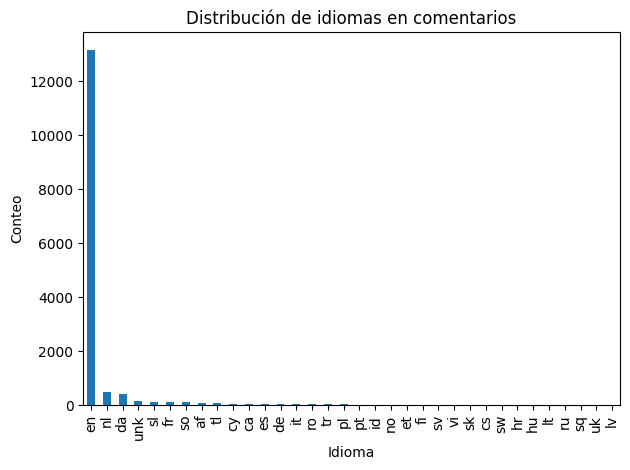

In [19]:
vc_lang = comments["lang"].value_counts().sort_values(ascending=False)
plt.figure()
vc_lang.plot(kind="bar")
plt.title("Distribución de idiomas en comentarios")
plt.xlabel("Idioma")
plt.ylabel("Conteo")
plt.tight_layout()
plt.savefig(figs_dir / "dist_idiomas_comentarios.png", dpi=150)
plt.show()

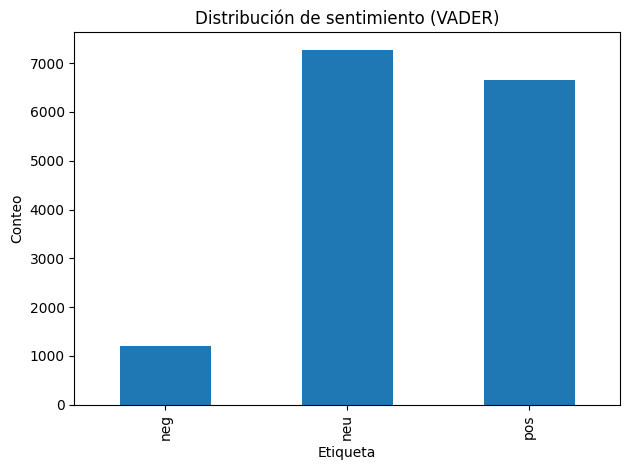

In [20]:
vc_sent = comments["sentiment_label"].value_counts().reindex(["neg","neu","pos"])
plt.figure()
vc_sent.plot(kind="bar")
plt.title("Distribución de sentimiento (VADER)")
plt.xlabel("Etiqueta")
plt.ylabel("Conteo")
plt.tight_layout()
plt.savefig(figs_dir / "dist_sentimiento_vader.png", dpi=150)
plt.show()

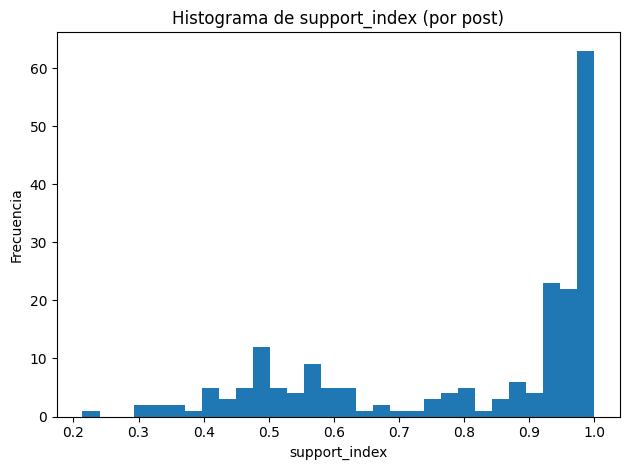

In [21]:
posts_enriched = read_df(ENRICHED_DIR / "posts_with_support.csv",
                         ENRICHED_DIR / "posts_with_support.jsonl")
if "support_index" in posts_enriched.columns:
    plt.figure()
    posts_enriched["support_index"].dropna().astype(float).plot(kind="hist", bins=30)
    plt.title("Histograma de support_index (por post)")
    plt.xlabel("support_index")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(figs_dir / "hist_support_index.png", dpi=150)
    plt.show()